## Exploratory Visualizations and Feature Selection
- Look at distributions.
- Look at correlations.
- Look at relationships to target (scatter plots for continuous, box plots for categorical).

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import json
from scipy import stats
import seaborn as sns


from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
train_df = pd.read_csv("./datasets/train_clean.csv")

In [3]:
test_df = pd.read_csv("./datasets/test_clean.csv")

### Scatter subplot and box subplot function

In [4]:
# define scatter subplot function 

def scatter_subplot(Dataframe, xlist, y):
    
    nrows = int(np.ceil(len(xlist)/2))
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols = ncols) 
    fig.set_figheight(nrows*8)
    fig.set_figwidth(15)
    plt.subplots_adjust(hspace = .5)
    
    for row in range(nrows):
        for col in range(ncols):
            index = row*2+col
            if index >= len(xlist):
                return
            ax=axes[row,col]
            xlabel = xlist[index]
            ax.set_title(xlabel + " / Price")
            sns.scatterplot(x=xlabel, y=y, data=Dataframe,ax=ax)
            sns.regplot(x=xlabel, y=y, data=Dataframe, scatter=False, ax=ax)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(y)

In [5]:
# define boxplot subplot function
def boxplot_subplot(Dataframe, xlist, y):
    
    nrows = int(np.ceil(len(xlist)/2))
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols = ncols) 
    fig.set_figheight(nrows*8)
    fig.set_figwidth(15)
    plt.subplots_adjust(hspace = .5)
    sns.despine(left=True)
    
    for row in range(nrows):
        for col in range(ncols):
            index = row*2+col
            if index >= len(xlist):
                return
            ax=axes[row,col]
            xlabel = xlist[index]
            ax.set_title(xlabel + " / Price")
            sns.boxplot(x=xlabel, y=y, data=Dataframe,ax=ax)
            sns.regplot(x=xlabel, y=y, data=Dataframe, scatter=False, ax=ax)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(y)

### Explore correlation between features and SalePrice

In [6]:
#create corr matrix according to SalePrice
corr_matrix = train_df.corr()[['SalePrice']].sort_values('SalePrice')

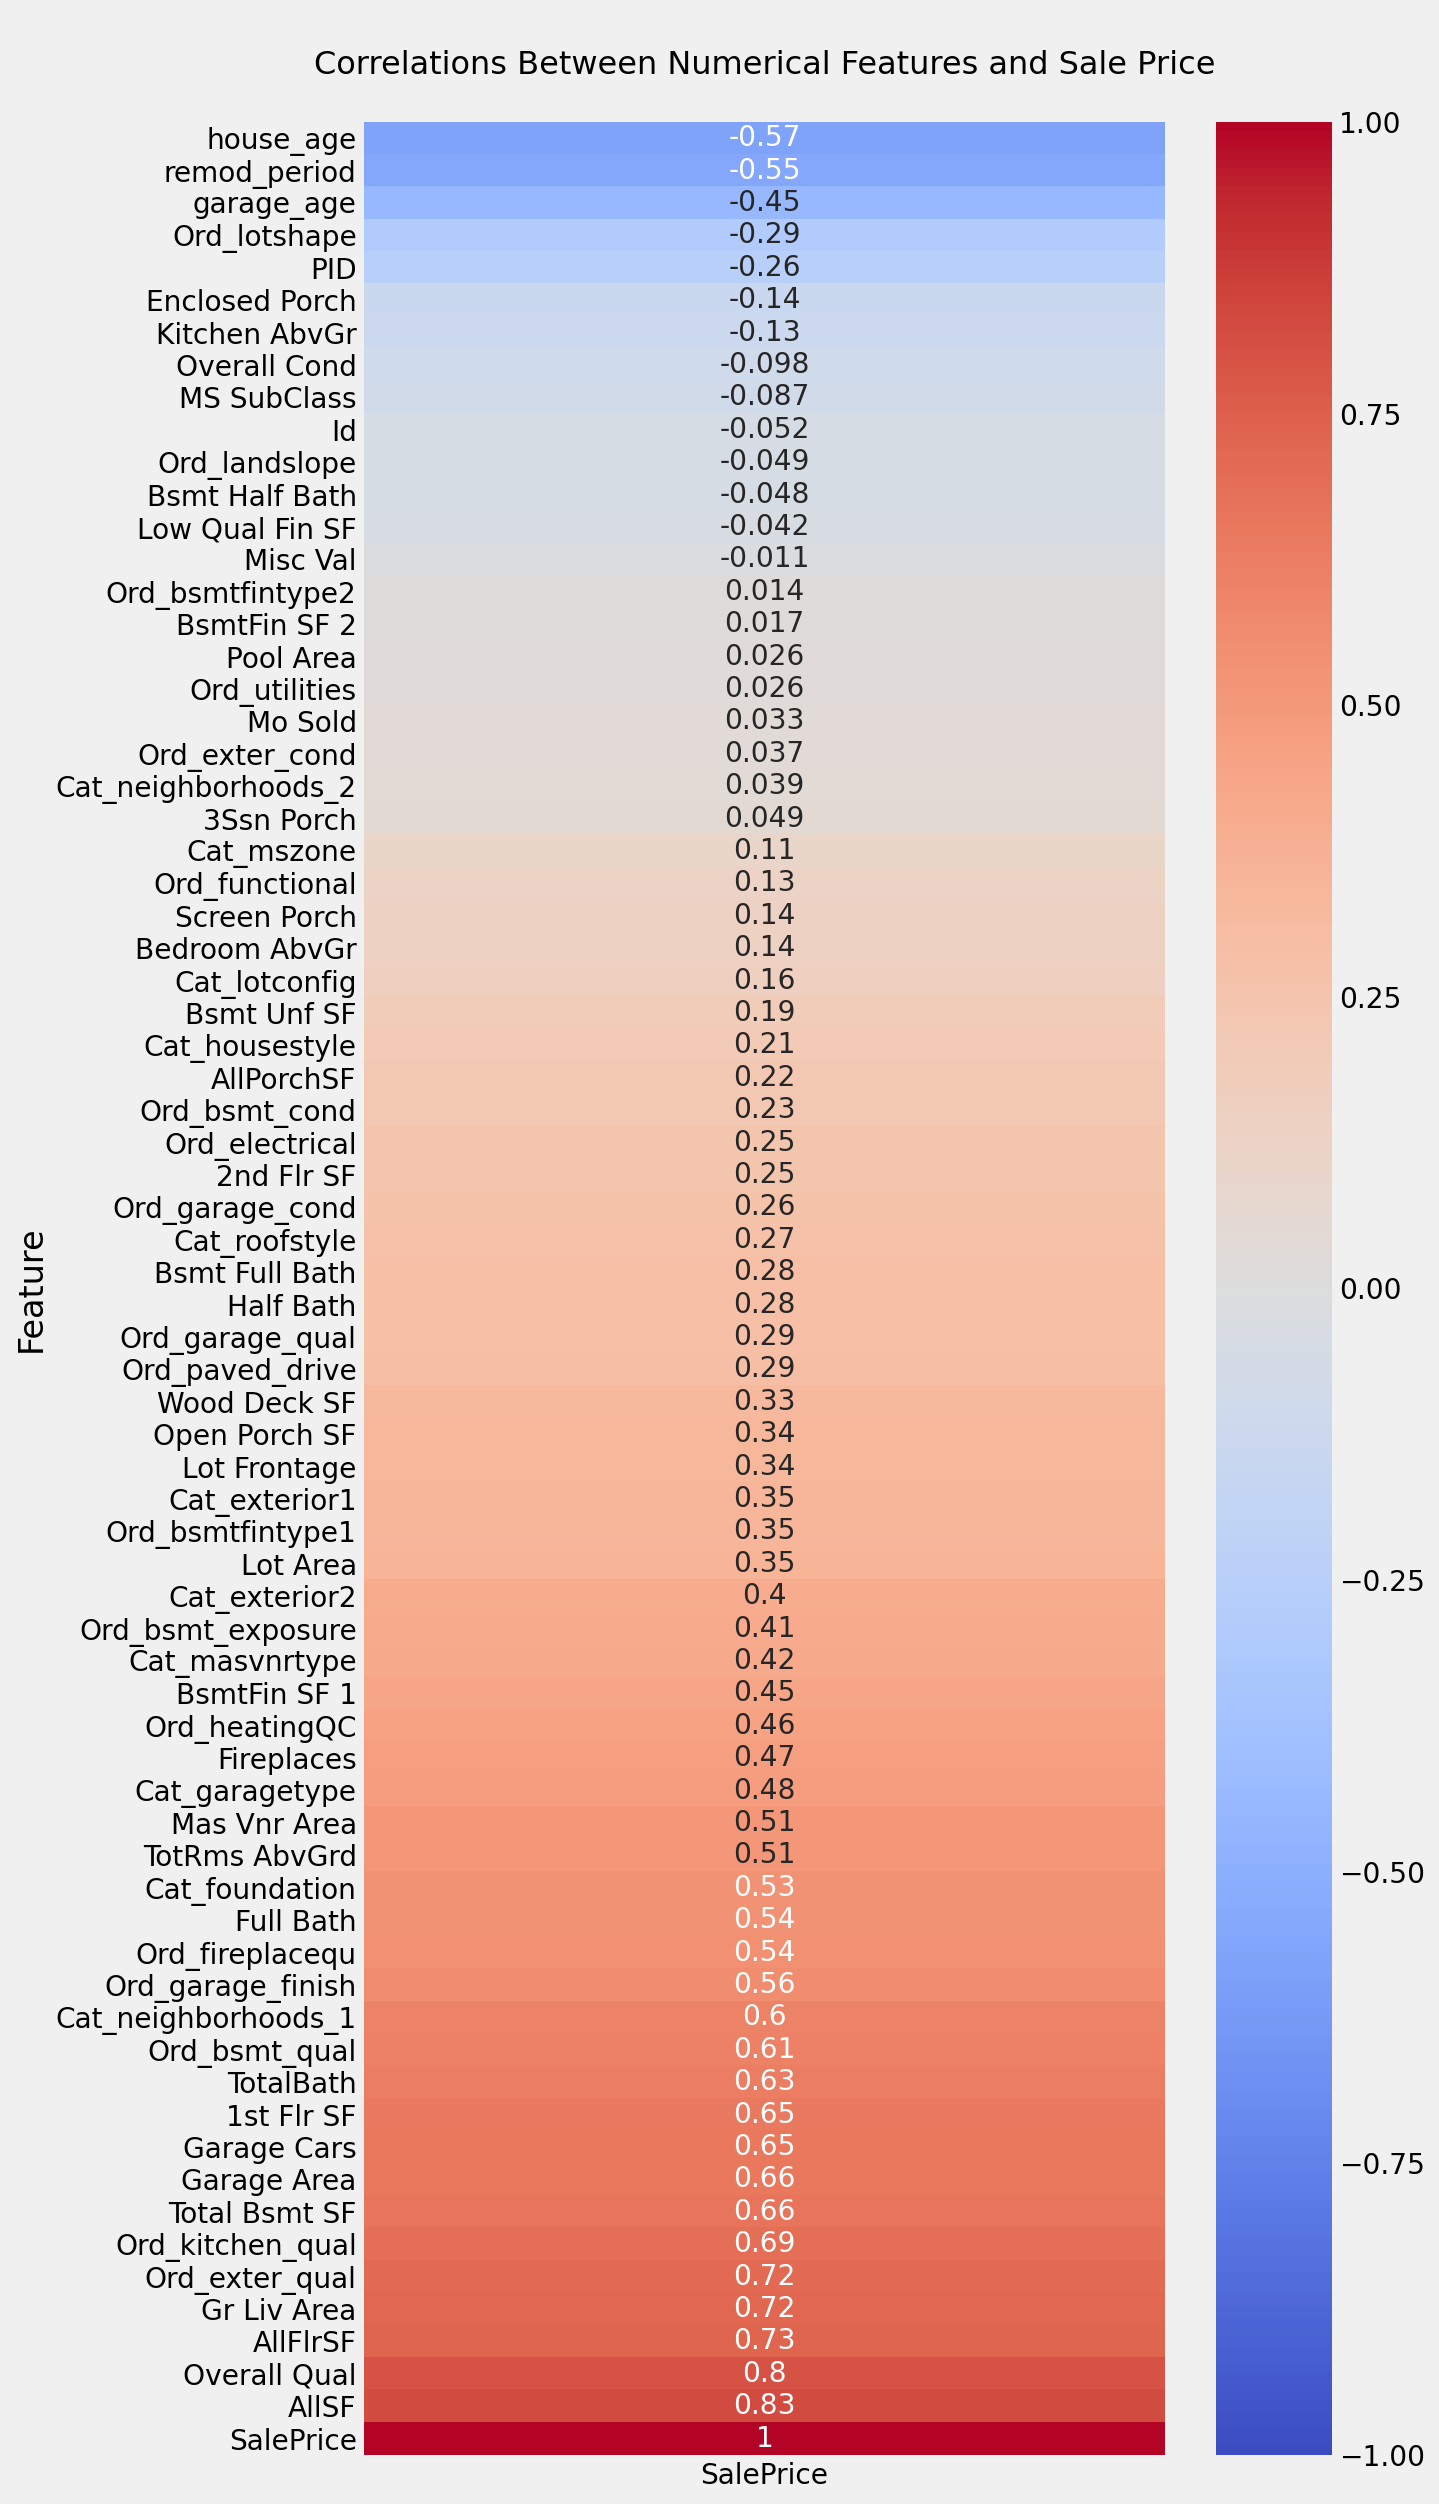

In [7]:
plt.figure(figsize=(8, 20))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.title('\nCorrelations Between Numerical Features and Sale Price\n', fontdict={'fontsize':16})
plt.ylabel('Feature');

In [8]:
corr_matrix = abs(train_df.corr()[['SalePrice']].sort_values('SalePrice'))
filtered_features = corr_matrix.loc[corr_matrix['SalePrice'] >= 0.4, :]

In [9]:
filtered_features_list = filtered_features.index.tolist()

In [10]:
# Extract feature with float data type 

filtered_features_float = [item for item in filtered_features_list if (train_df[item].dtype == float)]

In [11]:
# Extract feature with int data type 
filtered_features_int = [item for item in filtered_features_list if ((train_df[item].dtype != float) and (item != 'SalePrice'))]

In [12]:
# exclude categorical feature from filtered_features_int
filtered_features_int = [item for item in filtered_features_int if 'Cat_' not in item]

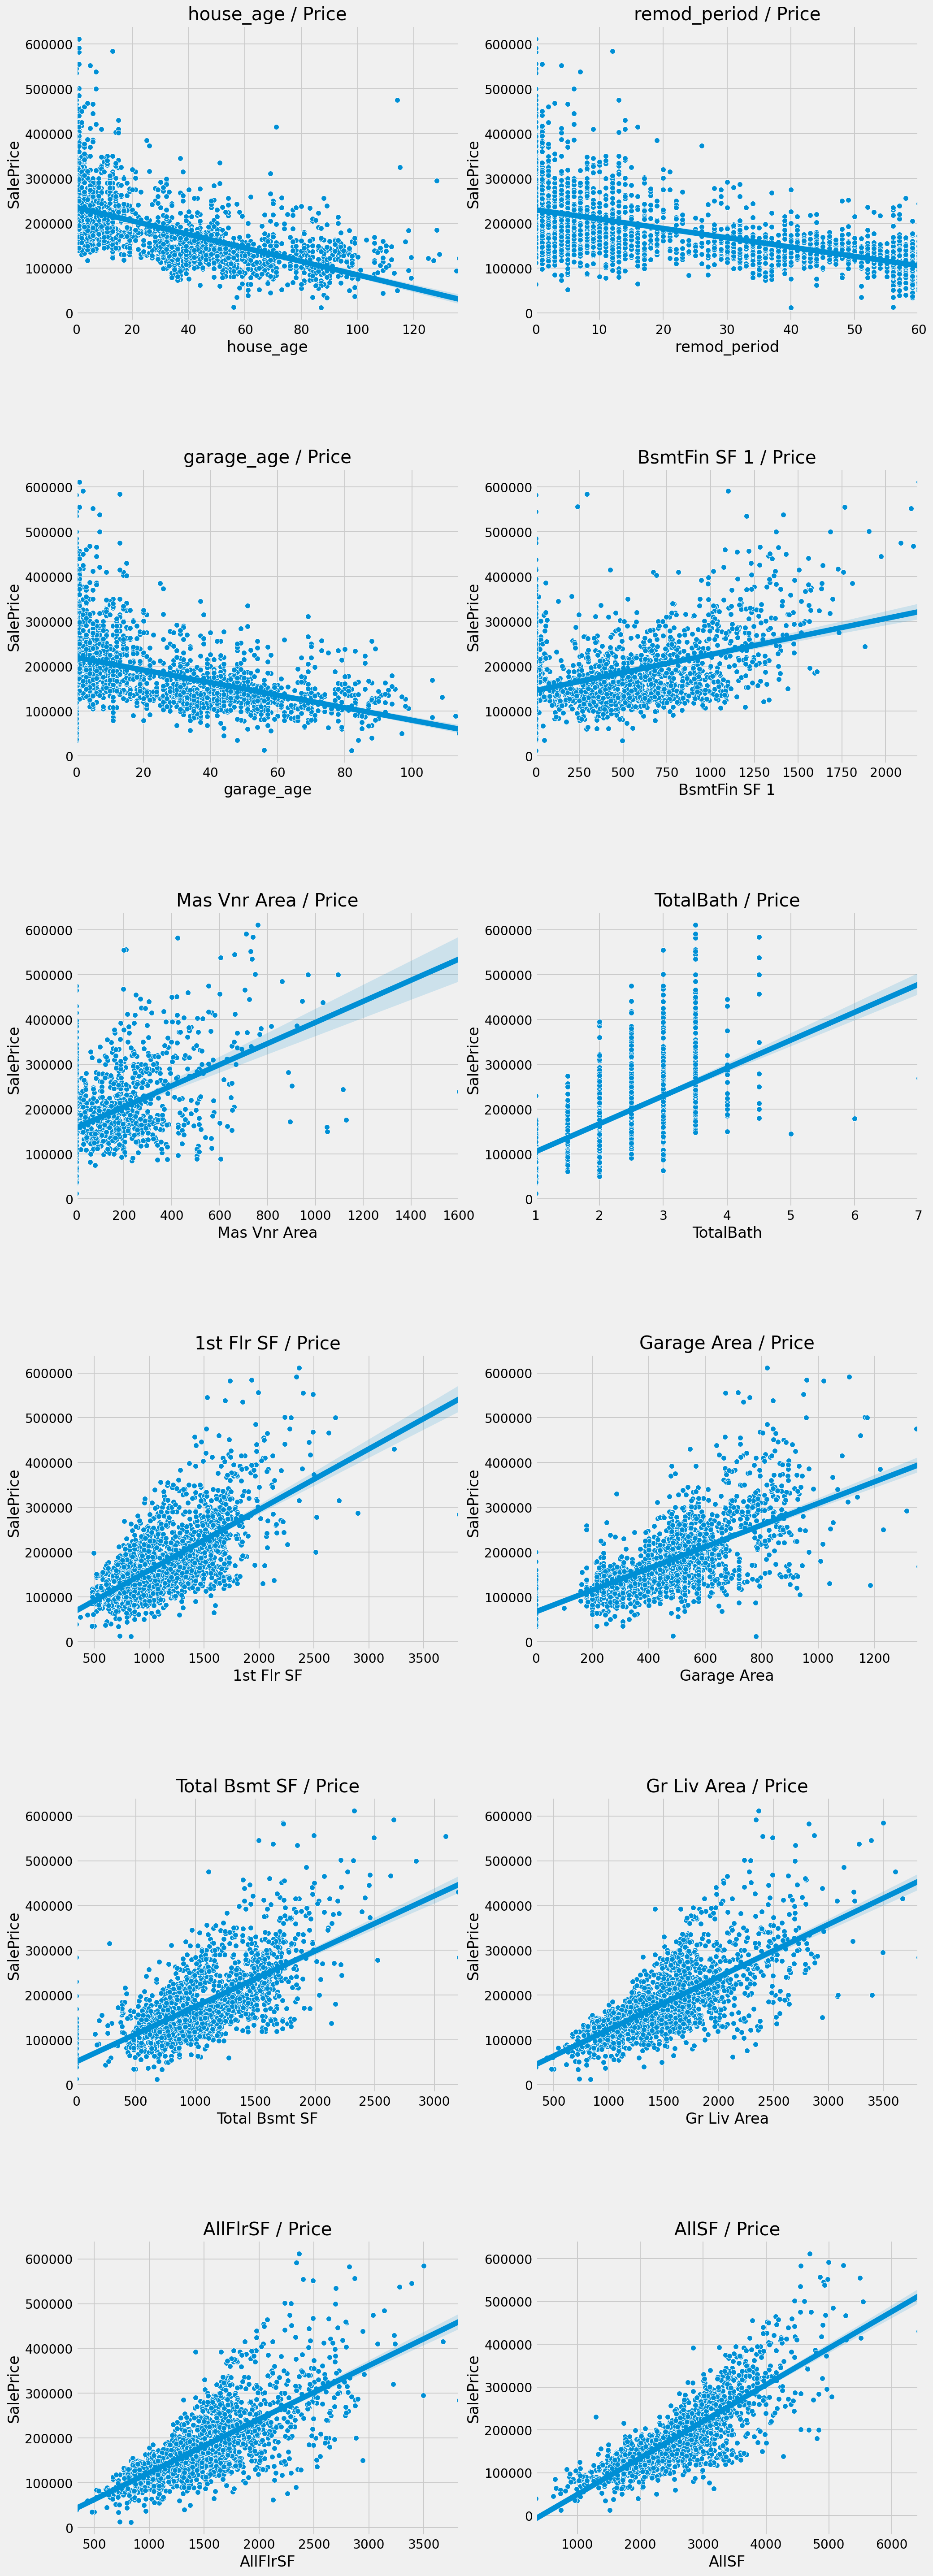

In [13]:
# Plot scatter plot for features with continous data 
xlist = filtered_features_float
y = 'SalePrice'
scatter_subplot(train_df, xlist, y)

**- Observation and interpretation for scatter plot**
- House_age / remod_period/garage_age have highly negative correlation with SalePrice. It is true from common sense that if the house is old, the sale price is low. 
- House area, like BsmtFin SF 1/ Mas Vnr Area/1st Flr SF/Garage Area/Total Bsmt SF/Gr Liv Area/AllFlrSF/AllSF, have highly positive correlation with SalePrice. 

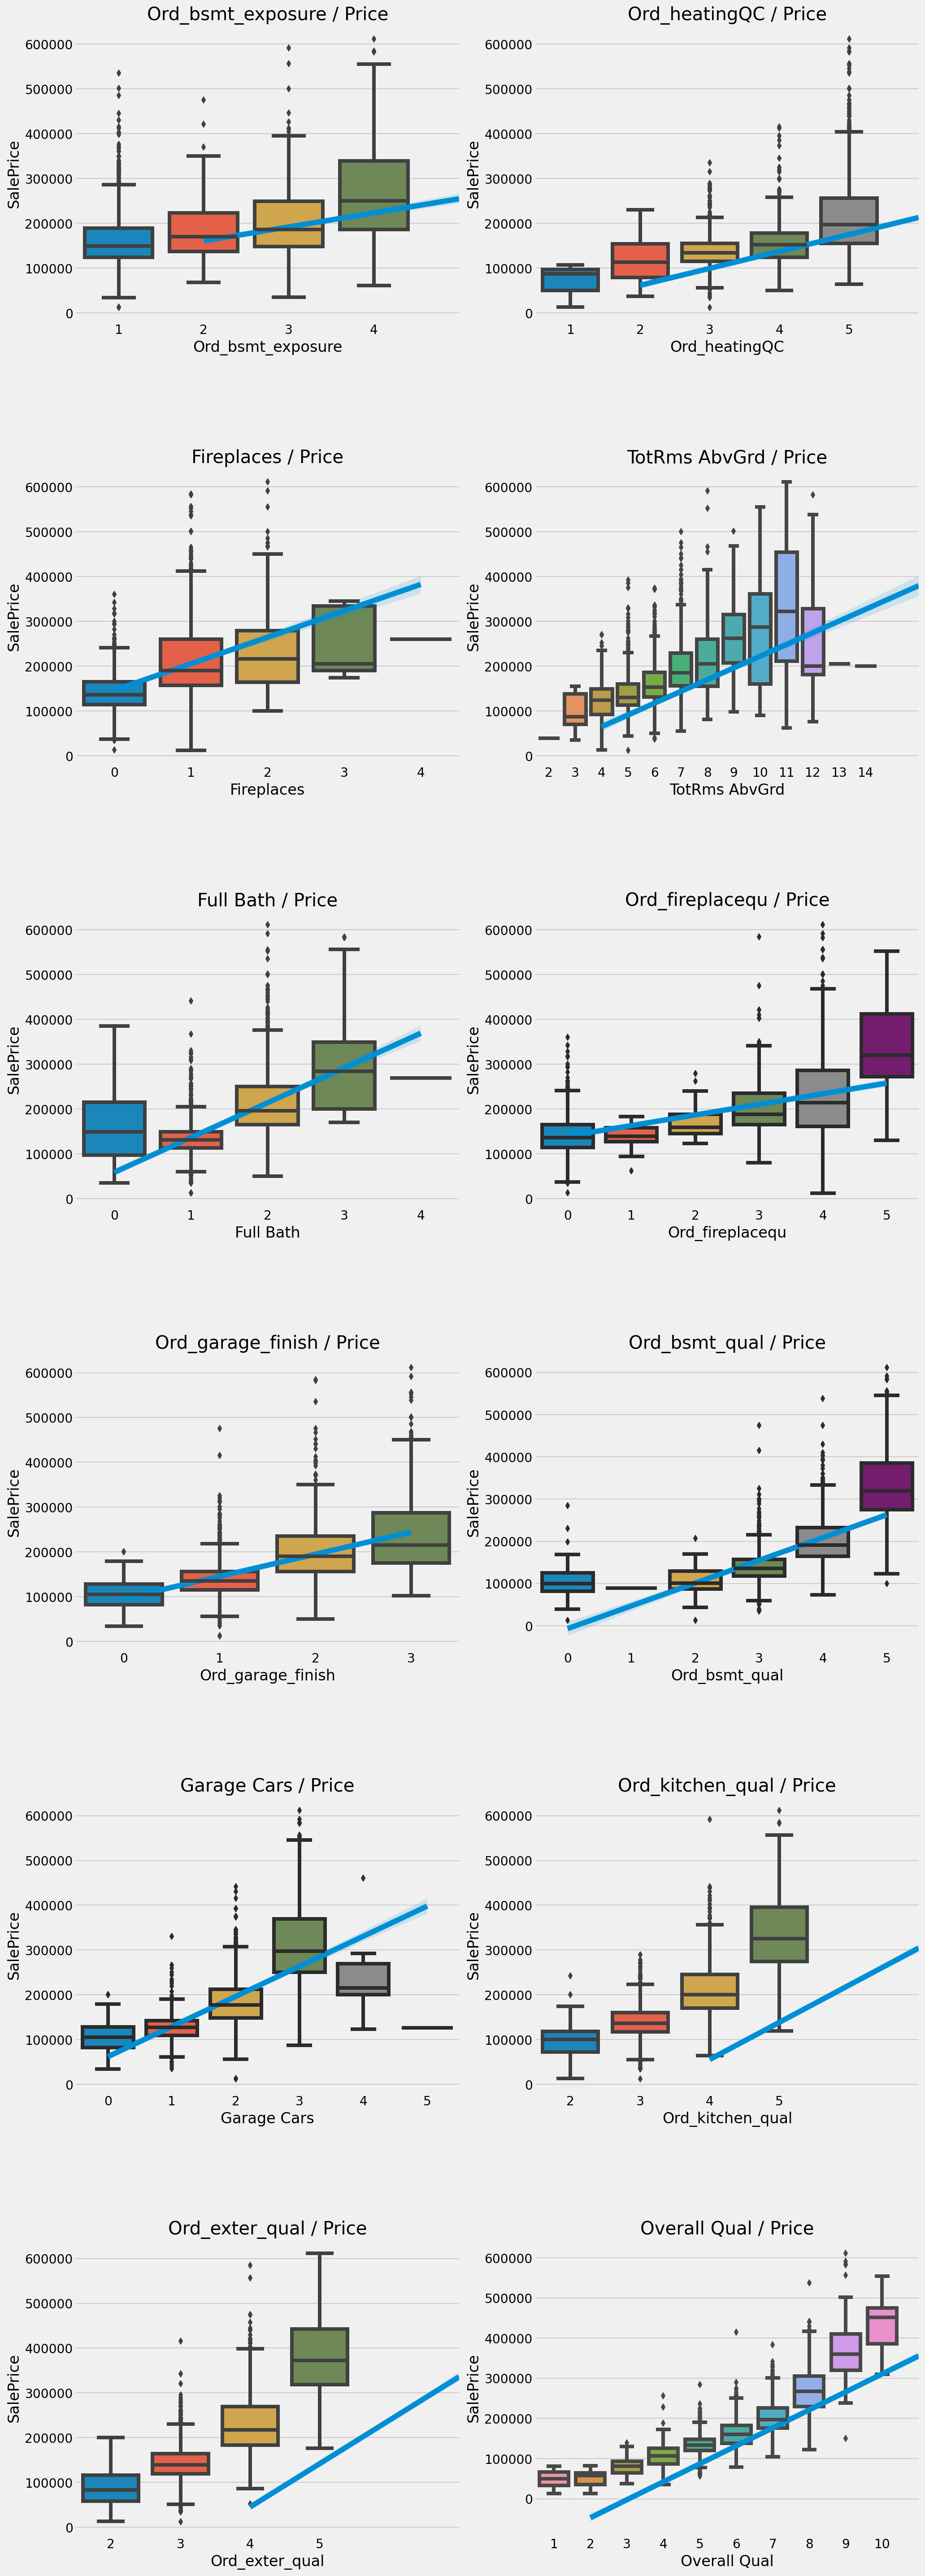

In [14]:
# Plot boxplot for features with discrete data 

xlist = filtered_features_int
y = 'SalePrice'
boxplot_subplot(train_df, xlist, y)

**- Observation and interpretation for scatter plot**
- We can observe from boxplot that these features have highly positive correlation with SalePrice except Garage cars. 
- For Garage car, when no of car increases to 4 or 5, Sale price decreases. Maybe people does not like house with huge car garage. 

#### Heatmap to check colinear between features

In [15]:
df = train_df[filtered_features_list]

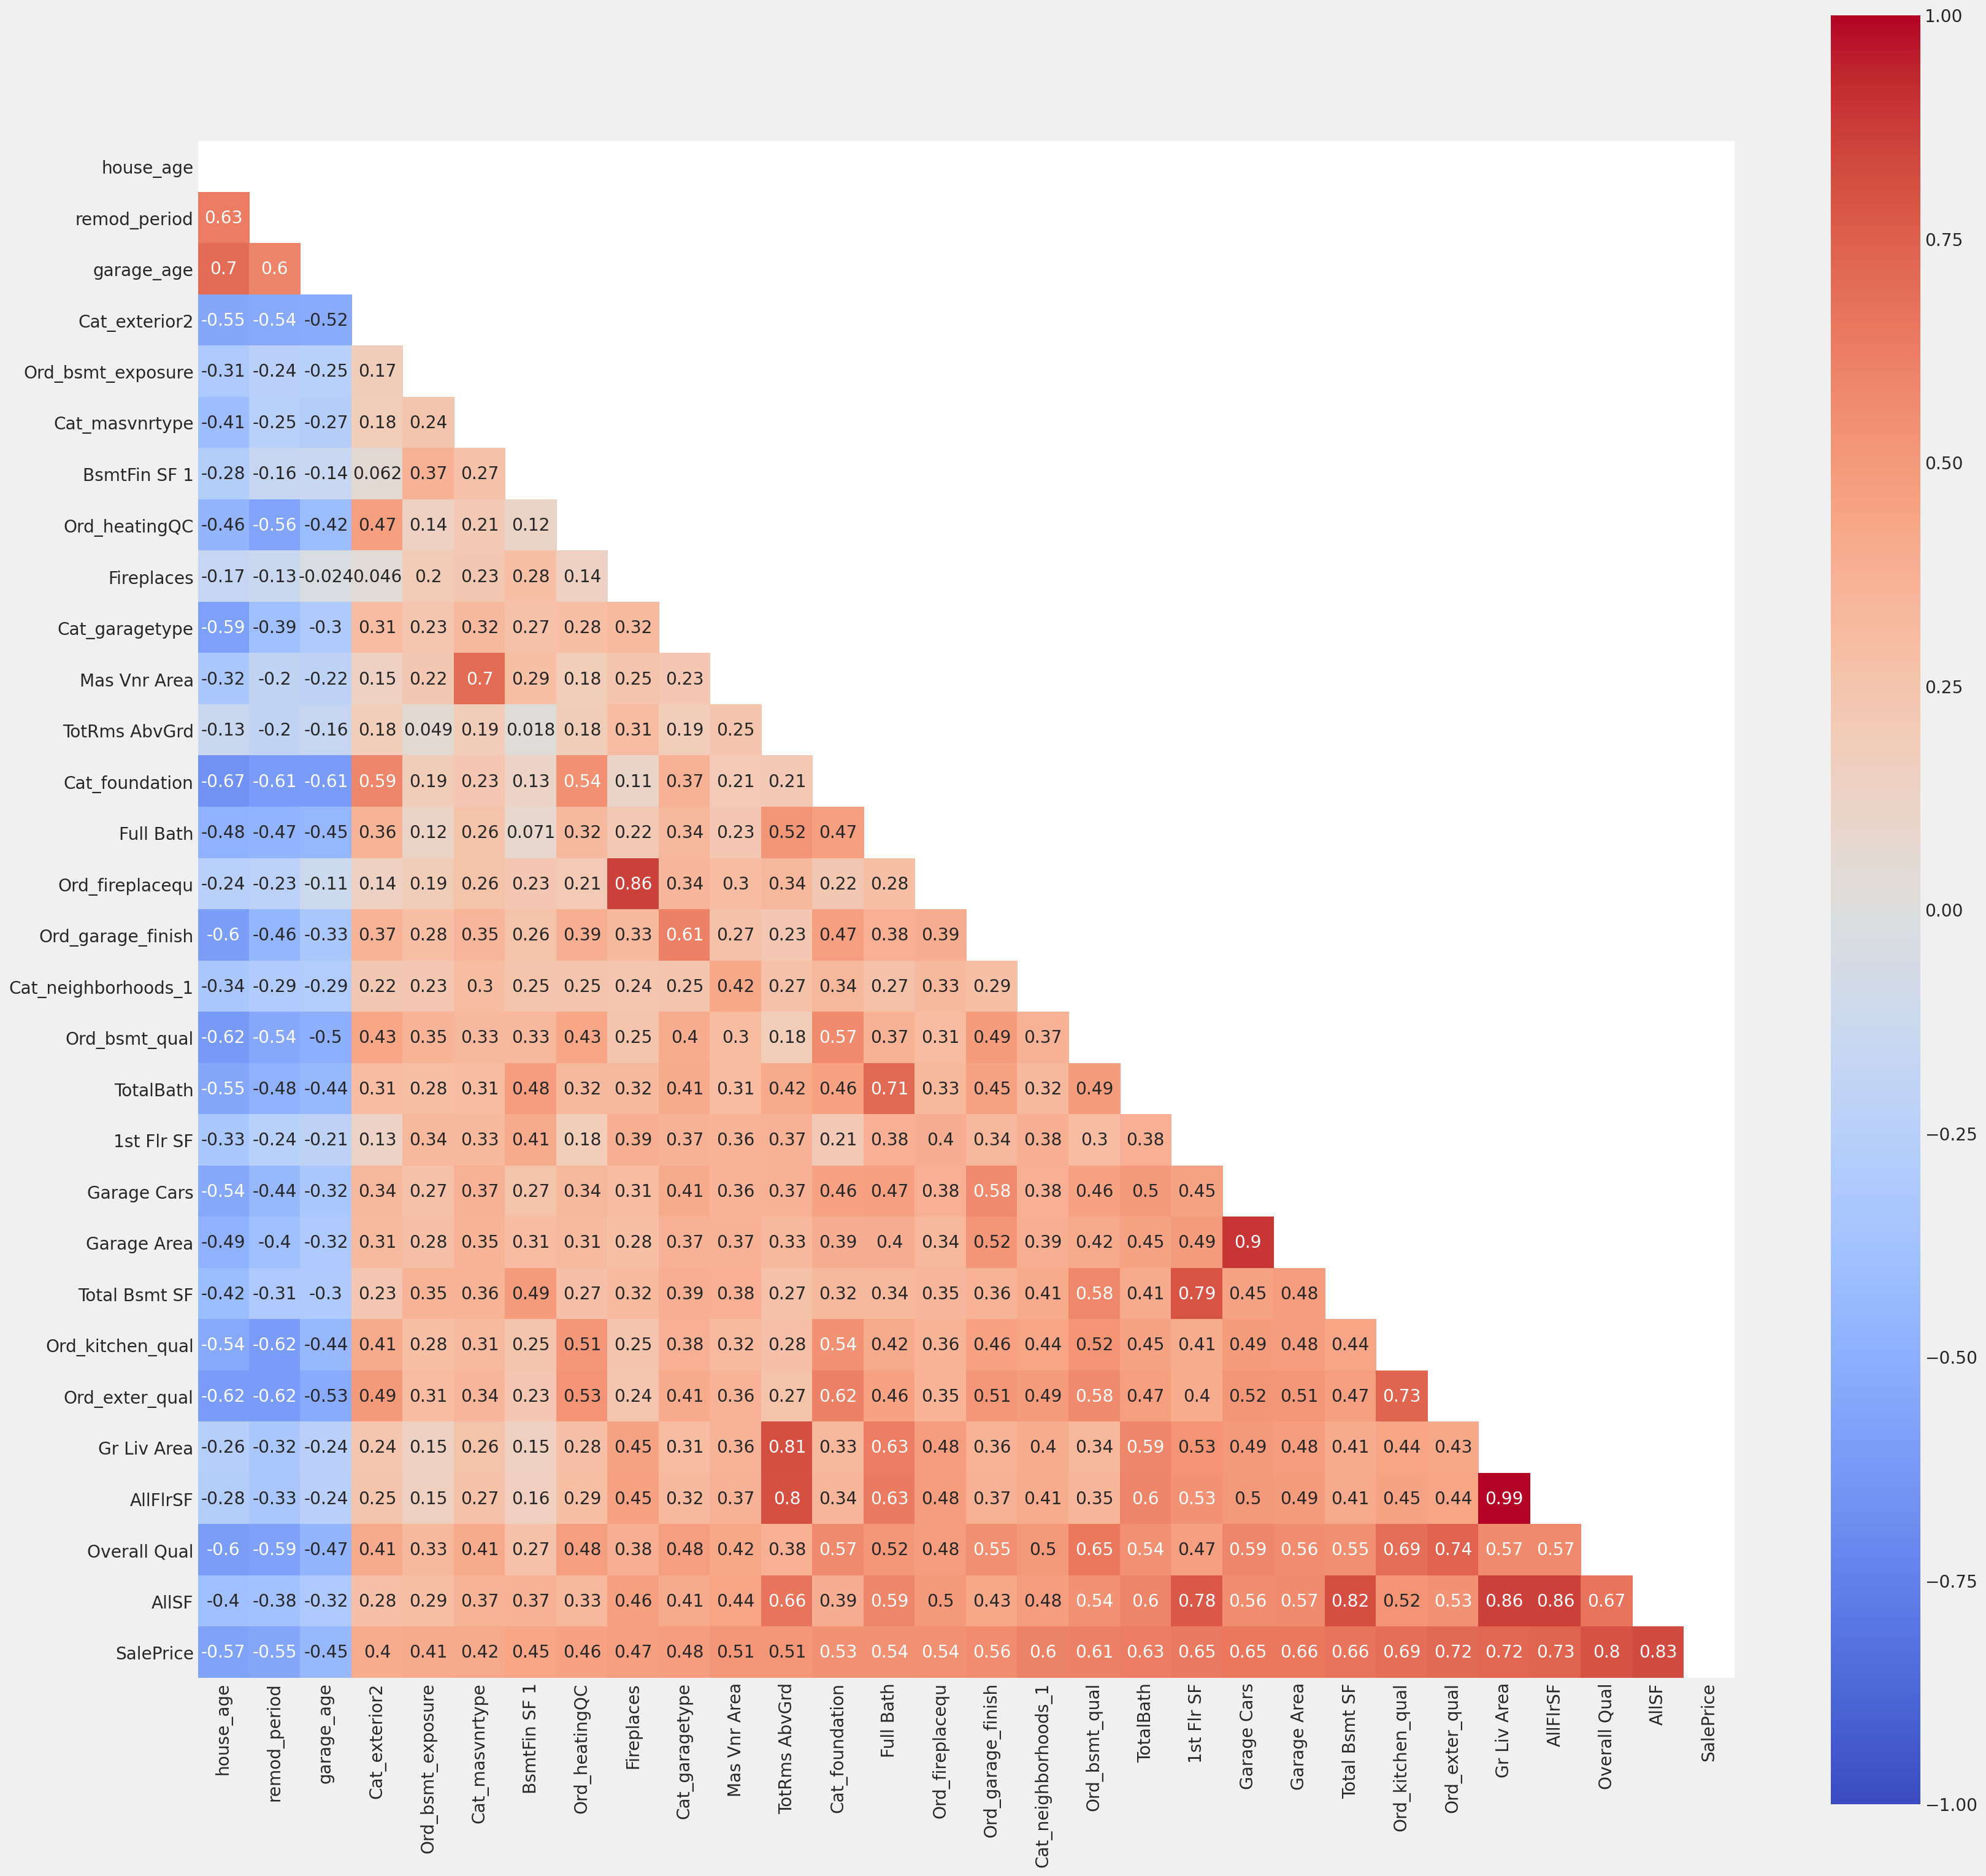

In [17]:
plt.figure(figsize=(25,25))
corr = np.corrcoef(df.corr())
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    sns.heatmap(df.corr(), mask=mask, square=True, vmin=-1,vmax=1, annot = True, cmap = 'coolwarm')

#### verify colinearity between input variables
- Garage cars and garage area has highly positive correlation, so we drop garage cars due to higher correlation for garage area with Saleprice
- AllFltSF and Gr Liv Area has highly positive correlation, so we drop Gr Liv Area due to higher correlation for AllFltSF with SalePrice
- Firepalces and ordinal_FirepalceQu has highly positive correaltion, so we drop Firepalces due to higher correaltion ratio for ordinal_FirepalceQu with SalePrice 

In [18]:
# drop list for features
drop_list = ['Garage Cars','Firepalces', 'Gr Liv Area', 'SalePrice']

#### create the features list to our model 

In [19]:
# features list to our model
model_features_list1 = [item for item in filtered_features_list if item not in drop_list]

# categorical sub-list from model_features_list (seperate for standard scaler)
cat_sublist1 = [item for item in model_features_list1 if 'Cat_' in item]

# numeric sub-list from model_features_list (seperate for standard scaler)
num_sublist1 = [item for item in model_features_list1 if 'Cat_' not in item]

#### Histogram plot for features for model_features_list1

Histgrams are plotted to check the distribution of Sale Price and the features with high correlation rate with it. 

- SalePrice is not normally distributed but skew to higher sale price side. 
- house_age / remod_period/garage_age are bimodel distributed and more houses are new house or newly renovated. 
- Floor area features, like 1st Flr sf/Garage Area/Total Bsmt SF/AllFlrSF/AllSF are all not normally distributed, but skew to higher value side. 

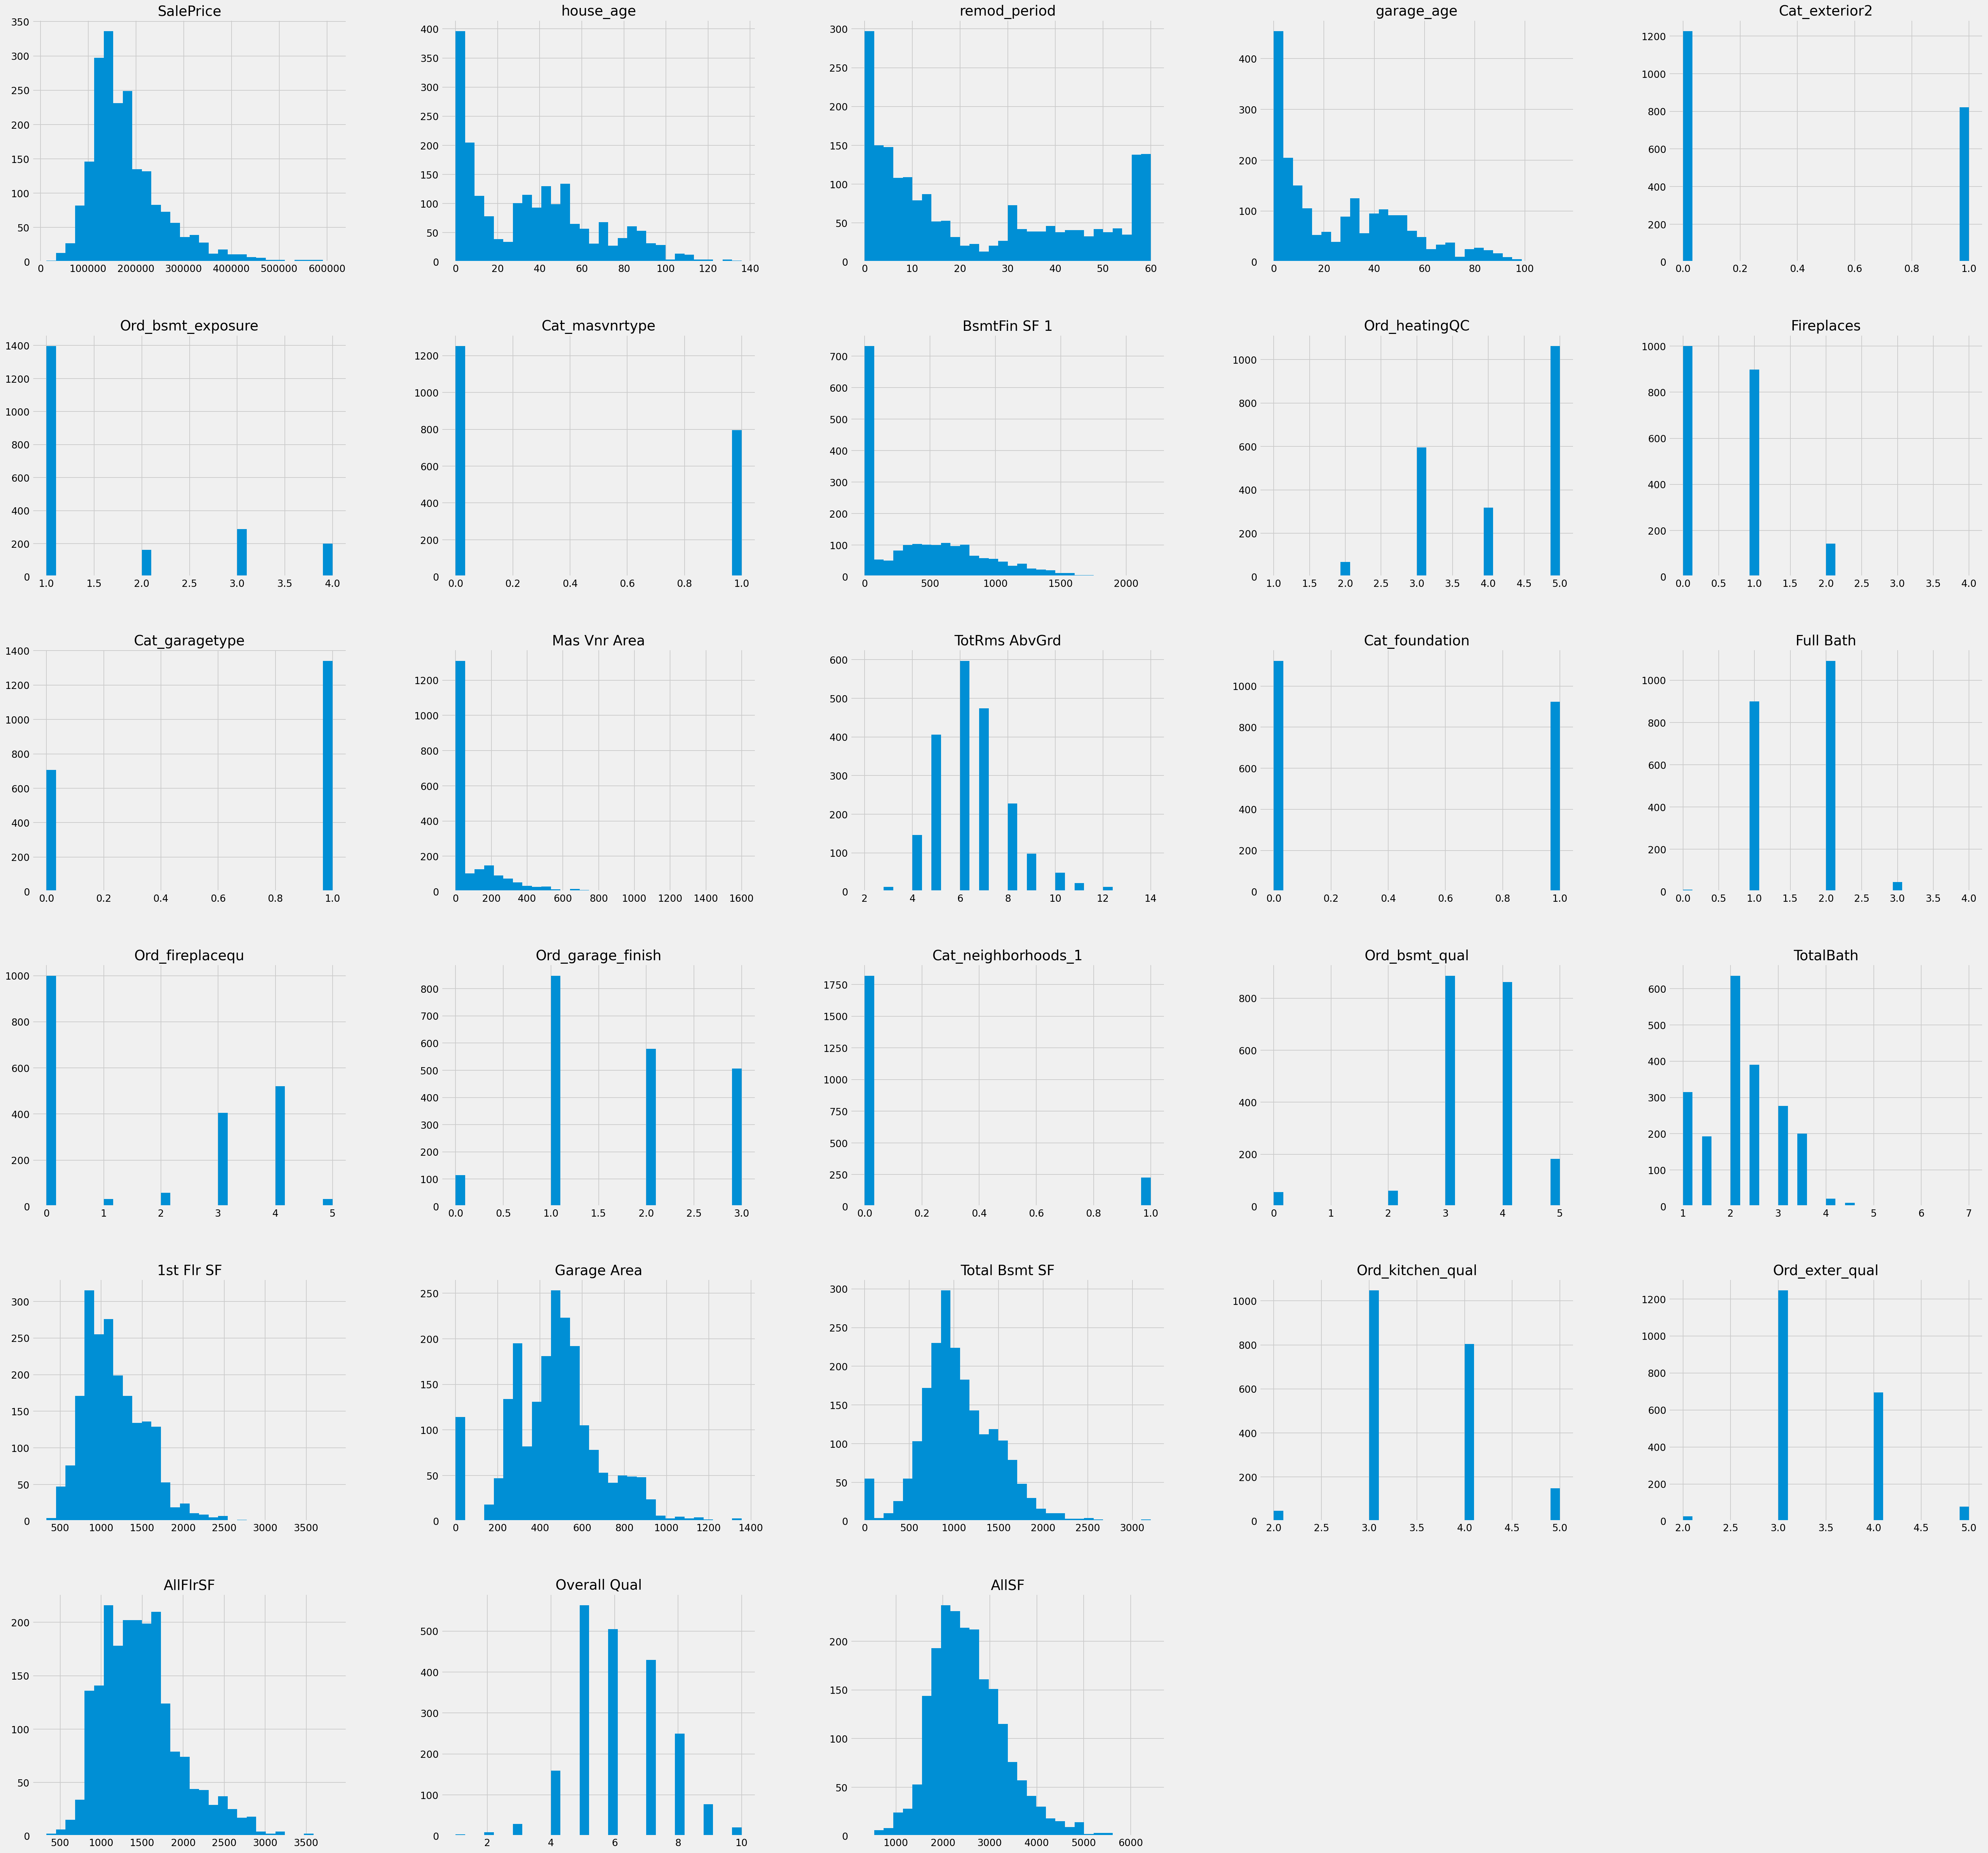

In [20]:
train_df[['SalePrice'] + model_features_list1].hist(figsize = (45, 45), bins = 30);

#### Save model features list and ready for model verification use

In [21]:
with open("./datasets/model_features_list1.txt", "w") as out:
    json.dump(model_features_list1, out)

In [22]:
with open("./datasets/num_sublist1.txt", "w") as out:
    json.dump(num_sublist1, out)

In [23]:
with open("./datasets/cat_sublist1.txt", "w") as out:
    json.dump(cat_sublist1, out)